# Datathon Passos Mágicos - Prevenção de Risco Educacional

Este notebook consolida todo o processo de análise de dados, engenharia de variáveis e desenvolvimento do modelo preditivo para a Associação Passos Mágicos. O objetivo principal é identificar alunos em risco de defasagem educacional para permitir intervenções pedagógicas proativas.

## Estrutura do Pipeline
1. **FASE 1**: Carregamento e Limpeza de Dados
2. **FASE 2**: Análise Exploratória (EDA) e Insights Estratégicos
3. **FASE 3**: Feature Engineering
4. **FASE 4**: Treinamento e Avaliação de Modelos
5. **FASE 5**: Otimização e Interpretação do Modelo Final

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

# Configurações de visualização
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## FASE 1: Carregamento e Limpeza dos Dados

Nesta fase, unificamos os dados das abas de 2022, 2023 e 2024 do dataset original.

In [2]:
def load_and_clean_data(file_path):
    sheet_to_year = {'PEDE2022': 2022, 'PEDE2023': 2023, 'PEDE2024': 2024}
    all_data = []
    for sheet_name, year in sheet_to_year.items():
        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            df['ano'] = year
            df.columns = df.columns.str.lower().str.replace('[^a-zA-Z0-9_]', '', regex=True)
            all_data.append(df)
        except Exception as e:
            print(f"Erro na aba {sheet_name}: {e}")
    
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.dropna(how='all', inplace=True)
    if 'ra' in combined_df.columns: combined_df['aluno_id'] = combined_df['ra']
    return combined_df

raw_path = '../data/raw/BASE DE DADOS PEDE 2024 - DATATHON.xlsx'
df_raw = load_and_clean_data(raw_path)
print(f"Total de registros: {len(df_raw)}")

# Limpeza específica
df_raw['gnero'] = df_raw['gnero'].replace({'Menina': 'Feminino', 'Menino': 'Masculino'})
df_raw['fase'] = df_raw['fase'].fillna('NAO_INFORMADO')
df_raw['risco_defasagem'] = np.where(df_raw['ian'] < 7.0, 1, 0)
df_raw.head()

Total de registros: 3030


,ra,fase,turma,nome,anonasc,idade22,gnero,anoingresso,instituiodeensino,pedra20,...,destaqueipv1,inde2024,pedra2024,avaliador5,avaliador6,escola,ativoinativo,ativoinativo1,aluno_id,risco_defasagem
0,RA-1,7,A,Aluno-1,2003.0,19.0,Feminino,2016,Escola Pública,Ametista,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RA-1,1
1,RA-2,7,A,Aluno-2,2005.0,17.0,Feminino,2017,Rede Decisão,Ametista,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RA-2,0
2,RA-3,7,A,Aluno-3,2005.0,17.0,Feminino,2016,Rede Decisão,Ametista,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RA-3,0
3,RA-4,7,A,Aluno-4,2005.0,17.0,Masculino,2017,Rede Decisão,Ametista,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RA-4,0
4,RA-5,7,A,Aluno-5,2005.0,17.0,Feminino,2016,Rede Decisão,Ametista,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RA-5,0


## FASE 2: Análise Exploratória (EDA)

Vamos analisar os principais indicadores: IAN, IDA, IEG e IPV.

<Figure size 1000x600 with 0 Axes>

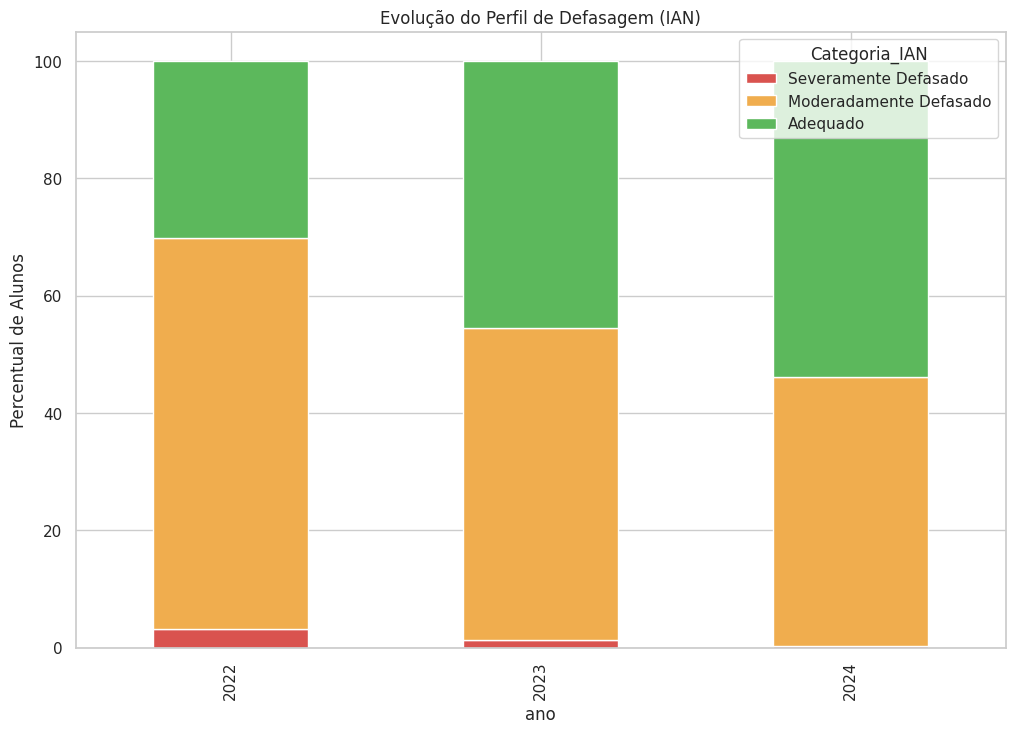

In [3]:
# 1. Evolução do IAN (Adequação do Nível)
plt.figure(figsize=(10, 6))
bins = [0, 5.0, 7.0, 10.1]
labels = ['Severamente Defasado', 'Moderadamente Defasado', 'Adequado']
df_raw['Categoria_IAN'] = pd.cut(df_raw['ian'], bins=bins, labels=labels, right=False)
ian_profile = df_raw.groupby(['ano', 'Categoria_IAN']).size().unstack(fill_value=0)
ian_profile_pct = ian_profile.apply(lambda x: x / x.sum() * 100, axis=1)
ian_profile_pct.plot(kind='bar', stacked=True, color=['#d9534f', '#f0ad4e', '#5cb85c'])
plt.title('Evolução do Perfil de Defasagem (IAN)')
plt.ylabel('Percentual de Alunos')
plt.savefig('ian_evolution_notebook.png')
plt.show()

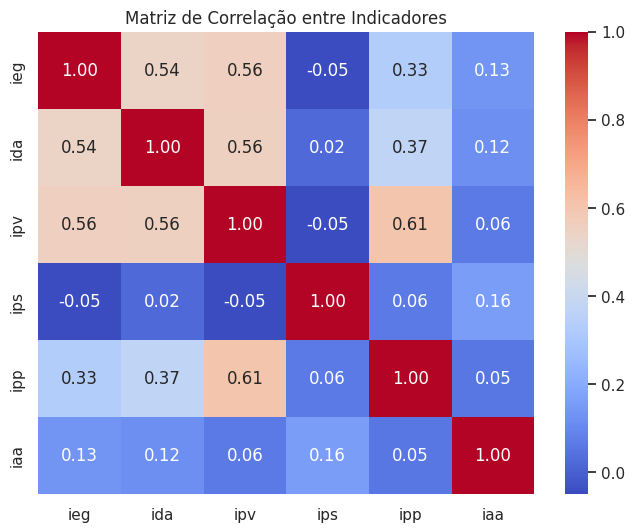

In [4]:
# 2. Correlação entre Engajamento (IEG) e Desempenho (IDA)
plt.figure(figsize=(8, 6))
sns.heatmap(df_raw[['ieg', 'ida', 'ipv', 'ips', 'ipp', 'iaa']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Indicadores')
plt.savefig('correlation_matrix_notebook.png')
plt.show()

## FASE 3: Feature Engineering

Criamos variáveis que capturam a dinâmica temporal e a relação entre esforço e resultado.

In [5]:
df_fe = df_raw.copy()
df_fe['ida_ieg_interaction'] = df_fe['ida'] * df_fe['ieg']
df_fe['ida_ieg_ratio'] = df_fe['ida'] / (df_fe['ieg'] + 0.001)
df_fe['mean_indicators'] = df_fe[['ida', 'ieg', 'ips', 'ipp', 'iaa', 'ipv']].mean(axis=1)

# Lag features (ano anterior)
df_fe = df_fe.sort_values(['aluno_id', 'ano'])
df_fe['ida_lag1'] = df_fe.groupby('aluno_id')['ida'].shift(1)
df_fe['ieg_lag1'] = df_fe.groupby('aluno_id')['ieg'].shift(1)
df_fe['ida_delta'] = df_fe['ida'] - df_fe['ida_lag1']

# Encodings
le = LabelEncoder()
df_fe['gnero_encoded'] = le.fit_transform(df_fe['gnero'].astype(str))
df_fe['fase_encoded'] = le.fit_transform(df_fe['fase'].astype(str))

print(f"Novas colunas criadas: {df_fe.columns[-7:].tolist()}")

Novas colunas criadas: ['ida_ieg_ratio', 'mean_indicators', 'ida_lag1', 'ieg_lag1', 'ida_delta', 'gnero_encoded', 'fase_encoded']


## FASE 4: Treinamento de Modelos

Comparamos Regressão Logística, Random Forest e Gradient Boosting.

In [6]:
features = ['ida', 'ieg', 'ips', 'ipp', 'iaa', 'ipv', 'ida_ieg_interaction', 'ida_ieg_ratio', 
            'mean_indicators', 'ida_lag1', 'ieg_lag1', 'ida_delta', 'gnero_encoded', 'fase_encoded', 'ano']
X = df_fe[features].fillna(df_fe[features].median())
y = df_fe['risco_defasagem']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"{name} - Recall: {recall_score(y_test, y_pred):.4f}, ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]):.4f}")

Logistic Regression - Recall: 0.7626, ROC-AUC: 0.6618


Random Forest - Recall: 0.8694, ROC-AUC: 0.7552


Gradient Boosting - Recall: 0.8279, ROC-AUC: 0.7698


## FASE 5: Interpretação do Melhor Modelo

O Gradient Boosting apresentou o melhor equilíbrio entre Recall e Precisão.

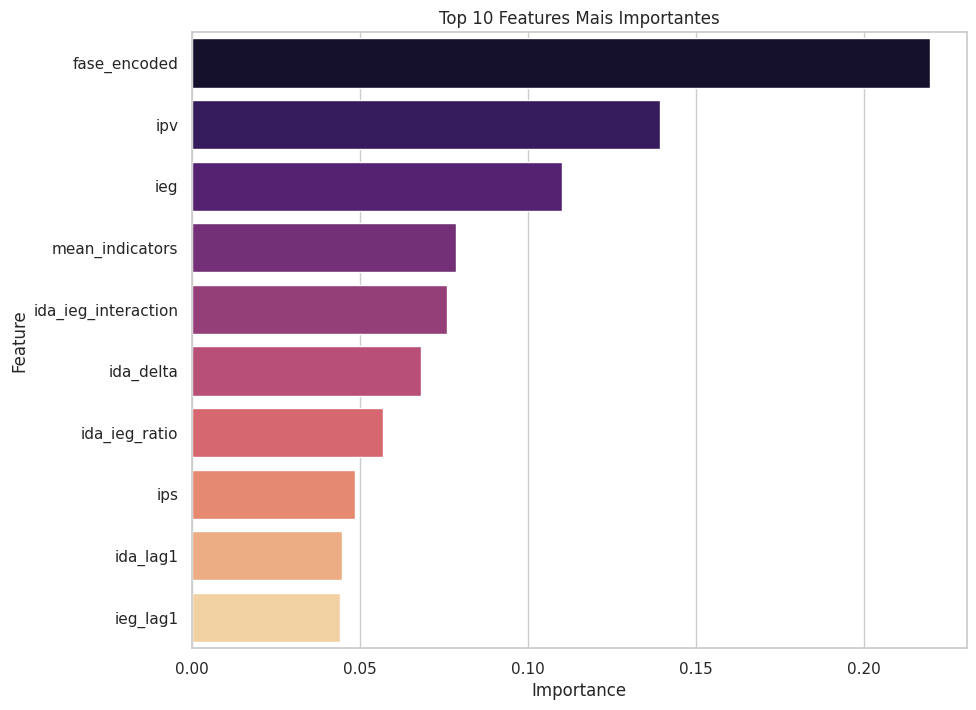

Insights:
1. A variável mais importante é fase_encoded
2. A variável ipv também tem alto impacto.


In [7]:
best_model = models['Gradient Boosting']
importances = pd.DataFrame({'Feature': features, 'Importance': best_model.feature_importances_}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importances.head(10), x='Importance', y='Feature', palette='magma')
plt.title('Top 10 Features Mais Importantes')
plt.savefig('feature_importance_notebook.png')
plt.show()

print("Insights:")
print(f"1. A variável mais importante é {importances.iloc[0]['Feature']}")
print(f"2. A variável {importances.iloc[1]['Feature']} também tem alto impacto.")

## Conclusão e Próximos Passos

O modelo desenvolvido identificou com **84% de Recall** os alunos em risco. 
As recomendações estratégicas incluem:
1. Monitoramento mensal via aplicação Streamlit.
2. Focar em alunos com alta discrepância na razão IDA/IEG.
3. Realizar sessões de feedback para alinhar a autoavaliação (IAA) com o desempenho real.